In [366]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [367]:
import os
from itertools import chain
import torch
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

from deepthermal.FFNN_model import fit_FFNN, FFNN, init_xavier
from deepthermal.validation import create_subdictionary_iterator, k_fold_cv_grid, add_dictionary_iterators
from deepthermal.plotting import plot_result, plot_model_1d

from neural_reparam.reparametrization import (
    get_elastic_metric_loss,
    compute_loss_reparam,
)
from neural_reparam.ResNet import ResNet
from neural_reparam.models import ResCNN, BResCNN, CNN
from neural_reparam.reinforcement_learning import fit_dqn_deterministic, get_state, is_end_state, get_epsilon_greedy, get_action_map, get_optimal_path, plot_solution, Env

import experiments.curves as c1

# make reproducible
seed = torch.manual_seed(0)

In [368]:
# Load data
N =32

x_train = torch.linspace(0,1 , N, requires_grad=True)
q_train = c1.q(x_train.unsqueeze(1).detach())
r_train = c1.r(x_train.unsqueeze(1).detach())

data = TensorDataset(x_train, q_train, r_train)


In [369]:
0######
DIR = "../figures/curve_1/"
SET_NAME = "conv_3"
PATH_FIGURES = os.path.join(DIR, SET_NAME)
if not os.path.exists(PATH_FIGURES):
    os.makedirs(PATH_FIGURES)
########


FOLDS = 1
# loss_func = get_elastic_metric_loss(r=c1.r, constrain_cost=1e3, verbose=False)
# no_penalty_loss_func = get_elastic_metric_loss(r=c1.r, constrain_cost=0, verbose=False)
depth = 4
num_actions = depth ** 2
action_map = get_action_map(depth=depth, data=data)
MODEL_PARAMS = {
    "model": [ResNet],
    "input_dimension": [2],
    "output_dimension": [num_actions],
    "activation": ["relu"],
    "n_hidden_layers": [2],
}

# extend the previous dict with the zip of this
MODEL_PARAMS_EXPERIMENT = {
    "neurons": [32],
}
TRAINING_PARAMS = {
    "env": [Env(depth)],
    "batch_size": [N**2//2],
    "start_state_index": [torch.LongTensor([0, 0])],
    "get_state": [get_state],
    "choose_action": [get_epsilon_greedy(epsilon=0.1, num_actions=num_actions)],
    "action_map": [action_map],
    "is_end_state": [is_end_state],
    "C": [5],
    "memory_size": [N**2],
}
# extend the previous dict with the zip of this
TRAINING_PARAMS_EXPERIMENT = {
    "optimizer": ["ADAM"],
    "num_epochs": [300],
    "verbose_interval": [30],
    "learning_rate": [0.1],
}

In [370]:
# create iterators
model_params_iter_1 = create_subdictionary_iterator(MODEL_PARAMS)
# model_params_iter = chain.from_iterable((model_params_iter_1, model_params_iter_2))

model_exp_iter = create_subdictionary_iterator(MODEL_PARAMS_EXPERIMENT, product=False)
exp_model_params_iter = add_dictionary_iterators(model_exp_iter, model_params_iter_1)

training_params_iter = create_subdictionary_iterator(TRAINING_PARAMS)
training_exp_iter = create_subdictionary_iterator(TRAINING_PARAMS_EXPERIMENT, product=False)
exp_training_params_iter = add_dictionary_iterators(training_exp_iter, training_params_iter)

Do the actual training

In [371]:
cv_results = k_fold_cv_grid(
    model_params=exp_model_params_iter,
    fit=fit_dqn_deterministic,
    training_params=exp_training_params_iter,
    data=data,
    folds=FOLDS,
    verbose=True,
    trials=1
)


Running model (trial=0, mod=0, k=0):
Parameters: ({'model': <class 'neural_reparam.ResNet.ResNet'>, 'input_dimension': 2, 'output_dimension': 16, 'activation': 'relu', 'n_hidden_layers': 2, 'neurons': 32}, {'env': <neural_reparam.reinforcement_learning.Env object at 0x131a1fdc0>, 'batch_size': 512, 'start_state_index': tensor([0, 0]), 'get_state': <function get_state at 0x1323ad430>, 'choose_action': <function get_epsilon_greedy.<locals>.epsilon_greedy at 0x1327ee9d0>, 'action_map': <function get_action_map.<locals>.action_map at 0x13218a9d0>, 'is_end_state': <function is_end_state at 0x131cde8b0>, 'C': 5, 'memory_size': 1024, 'optimizer': 'ADAM', 'num_epochs': 300, 'verbose_interval': 30, 'learning_rate': 0.1})
################################  0  ################################
Training Loss:  tensor(116.8971)
################################  30  ################################
Training Loss:  tensor(96.7757)
################################  60  ################################


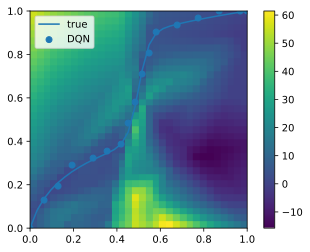

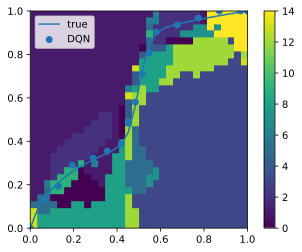

In [372]:
    model = cv_results["models"][0][0]
    with torch.no_grad():
        ksi = c1.ksi
        x_eval, *_ = data[:]

        N = len(data)
        ind = torch.tensor(np.indices((N, N)).T)
        grid = x_eval[ind]

        cost_matrix = torch.min(model(grid.float()).detach(), dim=-1)[0]
        indexes = get_optimal_path(q_model=model, action_map=action_map, data=data)

        fig, ax = plt.subplots(1)
        plot = ax.imshow(cost_matrix, extent=[0,1,0,1], origin="lower")
        plt.colorbar(plot)

        ax.scatter(x_eval[indexes[:, 0]], x_eval[indexes[:,1]],label="DQN")
        ksi_eval = ksi(x_eval.unsqueeze(1))
        ax.plot(x_eval, ksi_eval, label = "true")
        plt.legend()

        plt.show()
        cost_matrix = torch.argmin(model(grid.float()).detach(), dim=-1)
        indexes = get_optimal_path(q_model=model, action_map=action_map, data=data)

        fig, ax = plt.subplots(1)
        plot = ax.imshow(cost_matrix, extent=[0,1,0,1], origin="lower")
        plt.colorbar(plot)

        ax.scatter(x_eval[indexes[:, 0]], x_eval[indexes[:,1]],label="DQN")
        ksi_eval = ksi(x_eval.unsqueeze(1))
        ax.plot(x_eval, ksi_eval, label = "true")
        plt.legend()

        plt.show()

In [373]:
j# x_eval[indexes[:, 0]]
# indexes
N=30
ind = torch.tensor(np.indices((N, N)).T)
ind[:,:,1]
torch.linspace(0,1,N)[ind]


NameError: name 'j' is not defined